In [1]:
import os
import time

import cv2
import ipyplot
import skimage
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import metrics
from sklearn import cluster
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.cluster import spectral_clustering, DBSCAN, AffinityPropagation

from tools.utils import get_color_map

%matplotlib inline

In [2]:
def label_to_rgb(
    mask_label: np.ndarray,
    ) -> np.ndarray:
    mask_rgb = skimage.color.label2rgb(mask_label)
    mask_rgb = (mask_rgb * 255).astype(np.uint8)
    return mask_rgb

In [65]:
class TextColorizer:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

#### Initial parameters

In [38]:
study_name = '30_08_2019_test_01_liver'
series_name = '09_53_05_T3=80'
stem = '030_W=645_T3=80'
# series_name = '09_48_23_T1=60'
# stem = '030_W=645_T1=60'
box_offset = 5

#### Get paths to images

In [11]:
img_path_abs = os.path.join('dataset', 'HSI_sly_abs', study_name, series_name, 'img', f'{stem}.png')
img_path_hsv = os.path.join('dataset', 'HSI_sly_hsv', study_name, series_name, 'img', f'{stem}.png')
img_path_ref = os.path.join('dataset', 'HSI_sly_ref', study_name, series_name, 'img', f'{stem}.png')
ann_path = os.path.join('dataset', 'HSI_sly_abs', study_name, series_name, 'ann', f'{stem}.txt')
print(f'Images:\n{img_path_abs}\n{img_path_hsv}\n{img_path_ref}\n\nAnnotation:\n{ann_path}')

Images:
dataset/HSI_sly_abs/30_08_2019_test_01_liver/09_53_05_T3=80/img/030_W=645_T3=80.png
dataset/HSI_sly_hsv/30_08_2019_test_01_liver/09_53_05_T3=80/img/030_W=645_T3=80.png
dataset/HSI_sly_ref/30_08_2019_test_01_liver/09_53_05_T3=80/img/030_W=645_T3=80.png

Annotation:
dataset/HSI_sly_abs/30_08_2019_test_01_liver/09_53_05_T3=80/ann/030_W=645_T3=80.txt


#### Read images and annotations

Image shape: (744, 1000, 3)



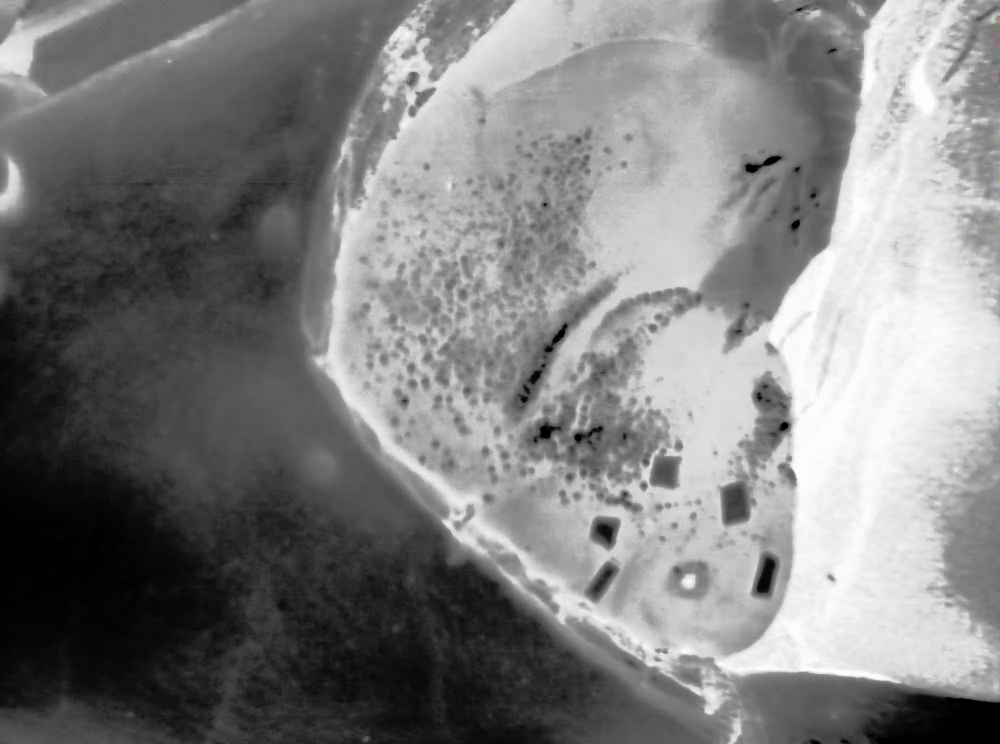
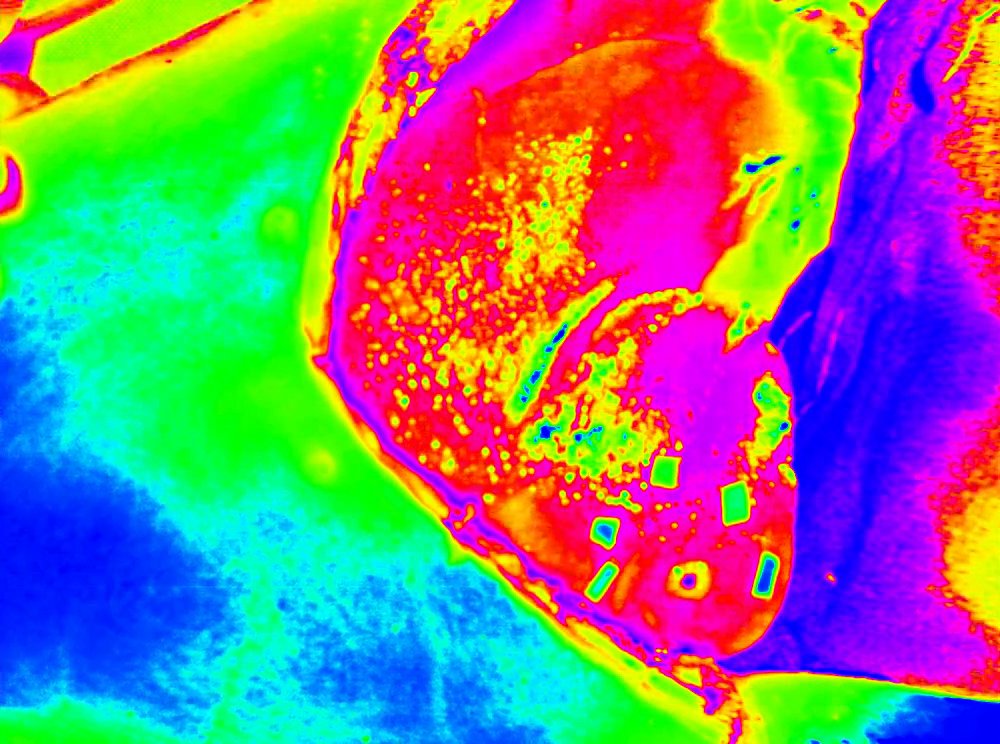
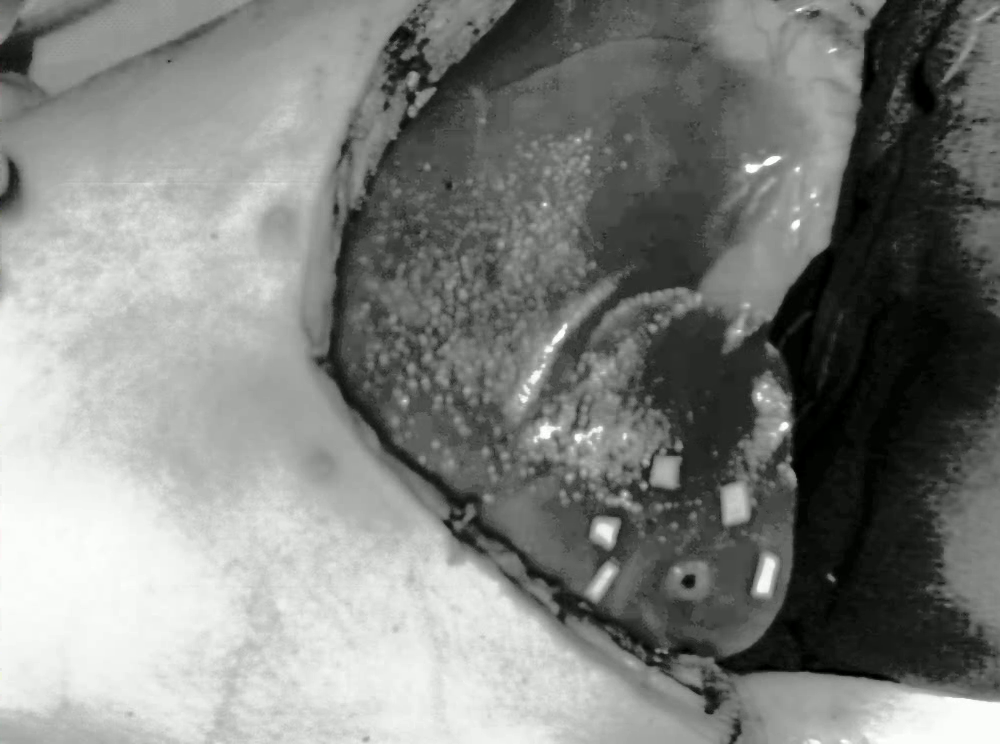


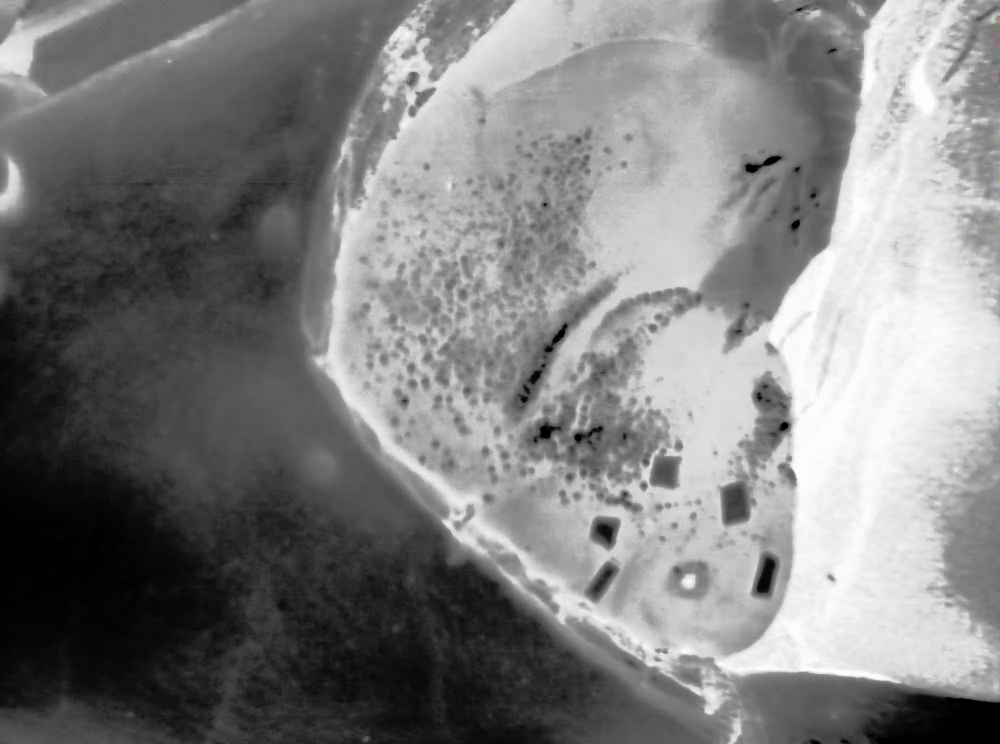
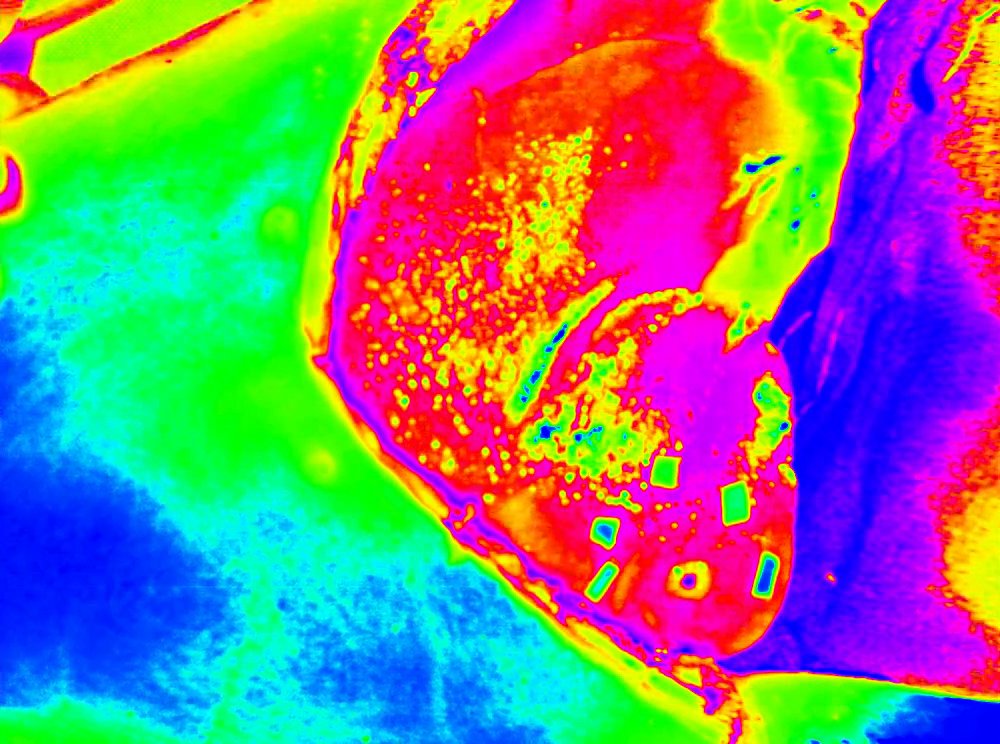
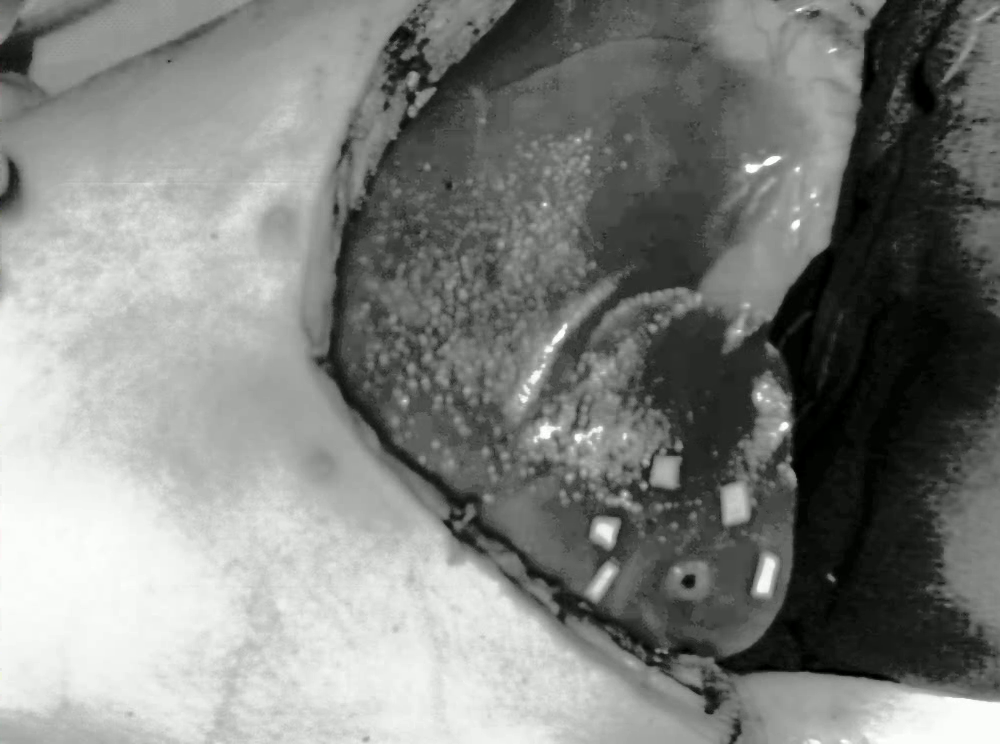

class_label    Zone
class_id          1
x1              664
y1              558
x2              712
y2              601
cx              688
cy              579
box_width        49
box_height       44
box_area       2156
Name: 0, dtype: object

In [12]:
img_abs = cv2.imread(img_path_abs)
img_abs = cv2.cvtColor(img_abs, cv2.COLOR_BGR2RGB)
img_hsv = cv2.imread(img_path_hsv)
img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_BGR2RGB)
img_ref = cv2.imread(img_path_ref)
img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)
print(f'Image shape: {img_abs.shape}')
ipyplot.plot_images([img_abs, img_hsv, img_ref], max_images=3, img_width=400)
box = pd.read_csv(ann_path, sep=' ', header=None)
box.columns = [
    'class_label',
    'class_id',
    'x1',
    'y1',
    'x2',
    'y2',
    'cx',
    'cy',
    'box_width',
    'box_height',
    'box_area',
]
box = box.iloc[0, :]
box

#### Box extension

Box shape: (53, 58, 3)



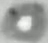
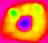
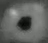
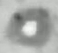
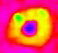
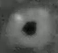


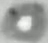
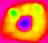
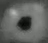
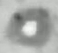
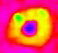
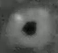

In [75]:
box_abs_src = img_abs[box['y1']:box['y2'], box['x1']:box['x2'], :]
box_hsv_src = img_hsv[box['y1']:box['y2'], box['x1']:box['x2'], :]
box_ref_src = img_ref[box['y1']:box['y2'], box['x1']:box['x2'], :]

box_abs = img_abs[box['y1']-box_offset:box['y2']+box_offset, box['x1']-box_offset:box['x2']+box_offset, :]
box_hsv = img_hsv[box['y1']-box_offset:box['y2']+box_offset, box['x1']-box_offset:box['x2']+box_offset, :]
box_ref = img_ref[box['y1']-box_offset:box['y2']+box_offset, box['x1']-box_offset:box['x2']+box_offset, :]
print(f'Box shape: {box_abs.shape}')
ipyplot.plot_images([box_abs_src, box_hsv_src, box_ref_src, box_abs, box_hsv, box_ref], max_images=6, img_width=400)

#### Stack and Transform images

In [72]:
box_abs_norm = cv2.normalize(box_abs, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
box_hsv_norm = cv2.normalize(box_hsv, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
box_ref_norm = cv2.normalize(box_ref, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
box_height, box_width, box_depth = box_abs.shape
_X = np.dstack((box_abs, box_hsv, box_ref))
# _X = np.dstack((box_abs_norm, box_hsv_norm, box_ref_norm))
X = _X.reshape(box_height*box_width, 3*box_depth)
print(f'Box shape......: {box_abs.shape}')
print(f'Source shape...: {_X.shape}')
print(f'Stack shape....: {X.shape}')

Box shape......: (53, 58, 3)
Source shape...: (53, 58, 9)
Stack shape....: (3074, 9)


#### K-Means

K-Means
Number of clusters: 5
Unique clusters: [  0  74 128 130 255]



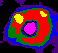
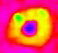
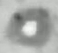
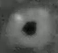


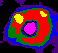
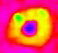
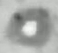
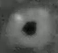

In [85]:
# Single image
X_ = box_abs.copy()
X = X_.reshape(box_height*box_width, box_depth)

# Triple image
# X_ = np.dstack((box_abs, box_hsv, box_ref))
# X_ = np.dstack((box_abs_norm, box_hsv_norm, box_ref_norm))
# X = X_.reshape(box_height*box_width, 3*box_depth)

# Clustering
num_clusters = 7
kmeans_cluster = cluster.KMeans(n_clusters=num_clusters, random_state=11)
kmeans_cluster.fit(X)
cluster_centers = kmeans_cluster.cluster_centers_
y_hat_ = kmeans_cluster.labels_
y_hat = y_hat_.reshape(box_height, box_width)
mask_kmeans = label_to_rgb(mask_label=y_hat)
num_clusters_kmeans = np.unique(mask_kmeans)
print(TextColorizer.BOLD + TextColorizer.OKGREEN + 'K-Means' + TextColorizer.ENDC)
print(f'Number of clusters: {len(num_clusters_kmeans)}')
print(f'Unique clusters: {num_clusters_kmeans}')
ipyplot.plot_images([mask_kmeans, box_hsv, box_abs, box_ref], max_images=4, img_width=350)
# OLD UNNECEESARY CODE
# mask = cluster_centers[y_hat_].reshape(box_height, box_width, 9)
# mask_kmeans_abs = mask[:, :, 0:3]
# mask_kmeans_hsv = mask[:, :, 3:6]
# mask_kmeans_ref = mask[:, :, 6:9]
# print(f'ABS shape...: {mask_kmeans_abs.shape}')
# print(f'HSV shape...: {mask_kmeans_hsv.shape}')
# print(f'REF shape...: {mask_kmeans_ref.shape}')
# ipyplot.plot_images([box_abs, box_hsv, box_ref, mask_kmeans_abs, mask_kmeans_hsv, mask_kmeans_ref], max_images=6, img_width=400)

#### Affinity propagation

Converged after 49 iterations.
Affinity propagation
Number of clusters: 2
Unique clusters: [  0 255]



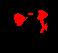
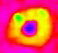
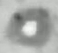
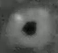


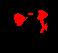
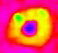
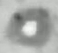
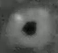

In [97]:
# Single image
X_ = box_abs.copy()
X = X_.reshape(box_height*box_width, box_depth)

# Triple image
# X_ = np.dstack((box_abs, box_hsv, box_ref))
# X_ = np.dstack((box_abs_norm, box_hsv_norm, box_ref_norm))
# X = X_.reshape(box_height*box_width, 3*box_depth)

# Clustering
model = AffinityPropagation(
    damping=0.90,
    max_iter=200,
    preference=None,
    affinity='euclidean',
    random_state=11,
    verbose=True,
    )
model.fit(X)
y_hat_ = model.predict(X)
y_hat = y_hat_.reshape(box_height, box_width)
mask_affinity = label_to_rgb(mask_label=y_hat)
num_clusters_affinity = np.unique(mask_affinity)
print(TextColorizer.BOLD + TextColorizer.OKGREEN + 'Affinity propagation' + TextColorizer.ENDC)
print(f'Number of clusters: {len(num_clusters_affinity)}')
print(f'Unique clusters: {num_clusters_affinity}')
ipyplot.plot_images([mask_affinity, box_hsv, box_abs, box_ref], max_images=4, img_width=350)

#### DBSCAN clustering

DBSCAN
Number of clusters: 11
Unique clusters: [  0  49  74 128 130 139 154 192 202 205 255]



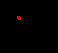
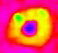
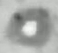
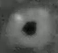


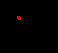
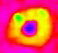
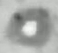
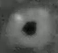

In [48]:
# Single image
X_ = box_abs.copy()
X = X_.reshape(box_height*box_width, box_depth)

# Triple image
# X_ = np.dstack((box_abs, box_hsv, box_ref))
# X_ = np.dstack((box_abs_norm, box_hsv_norm, box_ref_norm))
# X = X_.reshape(box_height*box_width, 3*box_depth)

# Clustering
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.3, min_samples=10, metric='euclidean').fit(X)
y_hat_ = np.zeros_like(db.labels_, dtype=bool)
y_hat_[db.core_sample_indices_] = True
y_hat_ = db.labels_
y_hat = y_hat_.reshape(box_height, box_width)
mask_dbscan = label_to_rgb(mask_label=y_hat)
num_clusters_dbscan = np.unique(mask_affinity)
print(TextColorizer.BOLD + TextColorizer.OKGREEN + 'DBSCAN' + TextColorizer.ENDC)
print(f'Number of clusters: {len(num_clusters_affinity)}')
print(f'Unique clusters: {num_clusters_affinity}')
ipyplot.plot_images([mask_dbscan, box_hsv, box_abs, box_ref], max_images=4, img_width=350)